In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data1 = Path("../SQL Extract/project_data.csv")
df = pd.read_csv(data1)
df.head()

# Binary Qualifiers - Create "OVER Limit = 1" and "Under Limit = 0"
df['Limit'] = [ 1 if x > 13 else 0 for x in df['TA.OVH.RECYCLE.NC4.VOLPCT']]

# Drop Lab data
df = df.drop(['TA.OVH.RECYCLE.NC4.VOLPCT'], axis = 1)

# Re-Order DF Columns
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1] # Move last to first
df = df[cols]
df


,Limit,Date,Index,RX.TB.RECYCLE.CHARGE.BPD,RX.TB.RECYCLE.CHARGE.PCT,RX.NORTH.TC.CHARGE.BPD,RX.NORTH.TC.CHARGE.CV.PCT,RX.NORTH.FLUSH.PSIG,RX.NORTH.OUT.F,RX.SOUTH.TA.RECYCLE.CHARGE.BPD,...,TC.TRAY7.F,TC.TRAY40.F,TC.CHARGE.F,TC.OVHD.PSIG,TC.OVHD.RECVR.F,TC.TRAY24.F,TC.DP.PSIG,TC.BTM.PSIG,TC.REBOIL.OUT.F,TC.REBOIL.COND.LBHR
0,0,7/15/22 13:00,0,2129.646240,18.000000,2675.764893,18.639069,154.651001,98.298904,6399.555664,...,189.015198,200.230911,185.963440,225.736343,171.159378,171.122482,3.474795,229.263306,201.866669,7962.539063
1,1,7/15/22 6:00,1,2272.000000,18.000000,2525.604736,16.987556,154.997070,94.095535,6395.504883,...,188.524796,200.025757,183.010101,225.407928,170.034485,166.026642,3.497400,228.925705,201.666885,8235.396484
2,1,7/14/22 13:00,2,2201.021484,18.000000,2205.657471,13.894874,154.587738,97.244797,5933.965332,...,189.106735,200.470154,184.994659,225.509613,170.889282,172.314682,3.255728,228.812592,202.100235,7684.425293
3,0,7/14/22 6:00,3,2298.876953,18.000000,2419.370850,15.557940,153.091431,94.886169,5902.112793,...,189.208466,200.854492,183.828537,227.577850,168.273529,167.599670,3.341954,230.949127,202.447525,7940.173828
4,0,7/13/22 13:00,4,2269.168213,18.000000,2569.280518,17.275063,149.634552,99.748436,5749.198730,...,188.840515,200.381729,185.034378,226.513702,168.064575,172.359161,3.218659,229.778030,202.280701,7591.852539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0,10/11/18 6:00,1850,3056.946045,27.000000,2853.280029,22.088940,121.349335,82.614143,6535.569824,...,192.336563,203.781128,194.393921,236.938599,173.135376,195.536072,3.412613,240.409851,205.255142,8013.027832
994,0,10/10/18 13:00,1851,2758.209473,16.000000,3005.921143,22.964691,121.833801,89.447021,6463.464844,...,193.257095,205.200195,195.721451,241.571411,170.776367,196.249710,3.301956,244.911194,206.848144,7750.328613
995,0,10/10/18 6:00,1852,2806.411865,19.077820,2775.908691,23.304472,122.098923,86.764534,6518.939453,...,191.543014,203.720093,193.072525,238.001022,170.092773,194.685394,3.406479,241.481781,205.371094,8153.497070
996,0,10/9/18 13:00,1853,2572.403076,0.000000,2738.953369,21.687014,121.345520,93.370056,6374.253906,...,192.551300,204.254166,194.869995,238.216949,172.189331,195.281830,3.427521,241.630554,205.950943,7602.535156


In [3]:
# Build Random Forest Model
y = df["Limit"]
X = df.drop(["Limit", "Date", "Index"], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=78, stratify=y)
## random_state is used to make the data reproducible. 
# Specifying a random state of 1 ensures that the same rows are assigned to train and test sets, respectively.
# A different random state number would distribute different rows of data to the train and test sets.
## Stratifying a dataset divides it proportionally. 
# For example, say that 60% of a dataset belongs to the yellow class, and 40% of it belongs to the purple class. 
# Stratifying it ensures that when the entire dataset is split into training and testing sets, 
# 60% of both will belong to the yellow class, and 40% will belong to the purple class.


## scaling is often necessary with models that are sensitive to large numerical values. 
# This is normally the case with models that measure distances between data points. 
# SVM is one model that usually benefits from scaling.
from sklearn.preprocessing import StandardScaler
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)
# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# import the SVC module from Scikit-learn,
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)
rf_model = rf_model.fit(X_train_scaled, y_train) 
y_pred = rf_model.predict(X_test_scaled)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))
results.head(20)


0.796


,Prediction,Actual
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,1
8,1,1
9,0,0


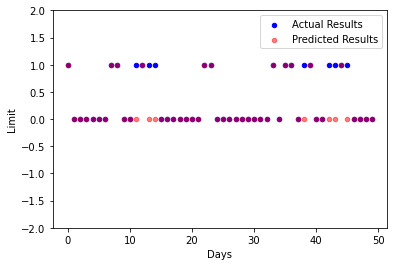

In [4]:
# Plot Results
# Create X-Axis for y
plot_df=pd.DataFrame(results)
count = []
i=0
for value in plot_df['Actual']:
    count.append(i)
    i=i+1
plot_df["Count"] = count  

plot_df.head()
plot_df["Actual"] = pd.to_numeric(plot_df["Actual"])
plot_df.dtypes
df = plot_df.head(50)
#Plot
ax = df.plot(kind="scatter", x="Count",y="Actual", color="b", label="Actual Results")
df.plot(kind="scatter" , x="Count",y="Prediction", color="r", label="Predicted Results", alpha = 0.5, ax=ax)


ax.set_xlabel("Days")
ax.set_ylabel("Limit")
ax.set_ylim(-2,2)
plt.show()


In [5]:
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, y_pred)
print(matrix)
report = classification_report(y_test, y_pred)
print(report)

[[151   9]
 [ 42  48]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.86       160
           1       0.84      0.53      0.65        90

    accuracy                           0.80       250
   macro avg       0.81      0.74      0.75       250
weighted avg       0.80      0.80      0.78       250



In [5]:
# Rank the Importance of Features
# One nice byproduct of the random forest algorithm is to rank the features by their importance, 
# which allows us to see which features have the most impact on the decision.

# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)


[(0.1365285408862025, 'TA.TRAY39.F'),
 (0.12161749874456941, 'TA.Tray4.F'),
 (0.08222720677340638, 'TA.OH.PSIG'),
 (0.08113187758918929, 'TA.OH.F'),
 (0.0649235928150107, 'TA.RECV.PSIG'),
 (0.0631511098988633, 'TA.BTM.REBOIL.OUT.F'),
 (0.06073301328923779, 'TA.BTM.PSIG'),
 (0.053475753666187384, 'TA.BTM.LEVEL.PCT'),
 (0.04882494348530968, 'TA.REFLUX.BPD'),
 (0.04551341392159538, 'TA.DP.PSIG'),
 (0.04247670352099094, 'TA.Charge.BPD'),
 (0.04192547597717936, 'TA.RECYCLE.TO.CONTACT.BPD'),
 (0.041852275822403355, 'TA.TOP.REBOIL.OUT.F'),
 (0.04089773202817262, 'TA.RECYCLE.TO.CONTACT.F'),
 (0.03937583990266919, 'TA.TRAY45.F'),
 (0.0353450216790127, 'TA.RECV.PCT')]